Objective: build a model predicting users’ demographic characteristics based on their app usage, geolocation, and cell phone properties. Furthermore, the goal is to aid developers and marketers engage in  data-driven efforts that are relevant to  and personalized to their end users preferences.

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os
import numpy as np # linear algebra
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
# filter warnings
warnings.filterwarnings('ignore')
import os
from subprocess import check_output

# Import various componenets for model building
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans

Using TensorFlow backend.


## Setting up the Data 

In [4]:
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gailyn","key":"f838642402b2c5fc90e6d2d0e8d7b171"}'}

In [5]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Nov  4 13:14 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so moving it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c talkingdata-mobile-user-demographics

  0% 0.00/1.05M [00:00<?, ?B/s]
100% 1.05M/1.05M [00:00<00:00, 67.5MB/s]
100% 4.04M/4.04M [00:00<00:00, 17.7MB/s]

  0% 0.00/7.67k [00:00<?, ?B/s]
100% 7.67k/7.67k [00:00<00:00, 7.01MB/s]
  0% 0.00/2.42M [00:00<?, ?B/s]
100% 2.42M/2.42M [00:00<00:00, 164MB/s]
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 42.9MB/s]
 80% 50.0M/62.2M [00:02<00:00, 17.5MB/s]
100% 62.2M/62.2M [00:02<00:00, 29.4MB/s]
 99% 209M/211M [00:05<00:00, 36.6MB/s]
100% 211M/211M [00:05<00:00, 41.9MB/s]
  0% 0.00/891k [00:00<?, ?B/s]
100% 891k/891k [00:00<00:00, 55.7MB/s]


In [9]:
!ls 

#now we have all of our data, lots to unzip! 

app_events.csv.zip	  kaggle.json
app_labels.csv.zip	  label_categories.csv.zip
events.csv.zip		  phone_brand_device_model.csv.zip
gender_age_test.csv.zip   sample_data
gender_age_train.csv.zip  sample_submission.csv.zip


In [0]:
import zipfile

In [0]:
# Unzipping all of the files to gain acess to csv for each subset 
with zipfile.ZipFile('app_events.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('app_events.csv')

with zipfile.ZipFile('app_labels.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('app_labels.csv')

with zipfile.ZipFile('events.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('events.csv')

with zipfile.ZipFile('gender_age_test.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('gender_age_test.csv')

with zipfile.ZipFile('gender_age_train.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('gender_age_train.csv')

with zipfile.ZipFile('label_categories.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('label_categories.csv')

with zipfile.ZipFile('phone_brand_device_model.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('phone_brand_device_model.csv')



In [0]:
apps = pd.read_csv('app_events.csv/app_events.csv')

In [0]:
apps = pd.read_csv(('app_events.csv/app_events.csv'),usecols=['event_id','app_id','is_active'], dtype={'is_active':bool})

In [0]:
genderTest = pd.read_csv('gender_age_test.csv/gender_age_test.csv')


In [0]:
genderTest = pd.read_csv(('gender_age_test.csv/gender_age_test.csv'), index_col= 'device_id')

In [0]:
genderTrain = pd.read_csv(('gender_age_train.csv/gender_age_train.csv'),index_col='device_id')

In [0]:
phone = pd.read_csv('phone_brand_device_model.csv/phone_brand_device_model.csv')

In [0]:
applables = pd.read_csv('app_labels.csv/app_labels.csv')

In [0]:
events = pd.read_csv(('events.csv/events.csv'), parse_dates=['timestamp'], index_col='event_id')

In [0]:
labelcats = pd.read_csv(('label_categories.csv/label_categories.csv'),index_col='label_id',squeeze=True)

In [0]:
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')

# Data Exploration

### I will start by exploring whats inside each of the subsets of the data

In [0]:
# Group is the variable we want to predict 
genderTrain

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38
-4938849341048082022,M,30,M29-31
245133531816851882,M,30,M29-31
...,...,...,...
4682031842235089751,M,30,M29-31
-9178703742877135986,M,30,M29-31
180946546684162312,M,20,M22-


In [0]:
genderTest

""
device_id
1002079943728939269
-1547860181818787117
7374582448058474277
-6220210354783429585
-5893464122623104785
...
4280900819321920929
818534825520551359
-8956851351560395765


In [25]:
apps

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True
...,...,...,...
32473062,3252948,6607018907660377991,True
32473063,3252948,6602285879264922467,True
32473064,3252948,4348659952760821294,True
32473065,3252948,-995726944612374565,True


In [0]:
phone

,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4
3669464369358936369,SUGAR,时尚手机
-5019277647504317457,三星,Galaxy Note 2
...,...,...
3210973037848940984,小米,MI 2S
7979541072208733273,小米,MI 4
-187404680852357705,小米,红米2


In [0]:
applables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459943 entries, 0 to 459942
Data columns (total 2 columns):
app_id      459943 non-null int64
label_id    459943 non-null int64
dtypes: int64(2)
memory usage: 7.0 MB


In [0]:
# Includes geo location, time, device 
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3252950 entries, 1 to 3252950
Data columns (total 4 columns):
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 124.1 MB


In [0]:
labelcats

label_id
1                       NaN
2            game-game type
3          game-Game themes
4            game-Art Style
5         game-Leisure time
               ...         
1017    Heritage Foundation
1018         Direct Banking
1019    Internet Securities
1020       Bank Credit Card
1021     Internet Insurance
Name: category, Length: 930, dtype: object

## Visualizations 

### Age

> The age of the users skews towards the younger side with the most active users being in their 20s, despite the average age represented is 31



In [0]:
genderTrain.describe()


,age
count,74645.000000
mean,31.410342
std,9.868735
min,1.000000
25%,25.000000
50%,29.000000
75%,36.000000
max,96.000000


In [0]:
print(genderTrain.age.mode())
print(genderTrain.age.min())
print(genderTrain.age.max())
print(genderTrain.age.median())

0    26
dtype: int64
1
96
29.0


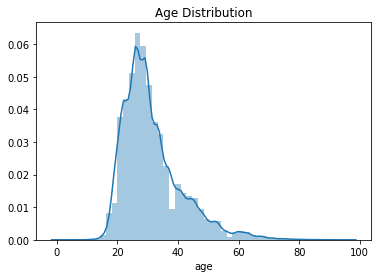

In [0]:
plt.title('Age Distribution')
#genderTrain.gender
sns.distplot(genderTrain.age)

### Gender 


> The dataset has a heavy empahsis on male users. When looking at category distribution, the most heavily populated categories are males 23 to 38. Overall when compaing in respective age groups the male users outnumber the female users. 



Text(0.5, 0, 'Count')

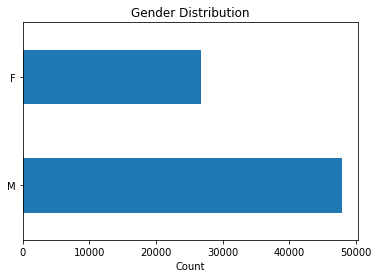

In [0]:
genderTrain.gender.value_counts().plot(kind='barh')
plt.title('Gender Distribution')
plt.xlabel('Count')

Text(0.5, 0, 'Individuals')

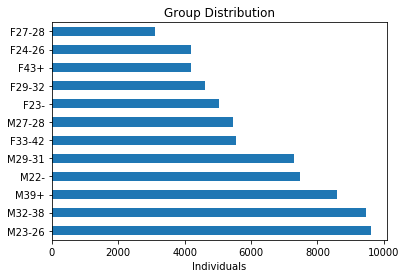

In [0]:
genderTrain.group.value_counts().plot(kind='barh')
plt.title('Group Distribution')
plt.xlabel('Individuals')

# App Usage 

Text(0.5, 0, 'Count')

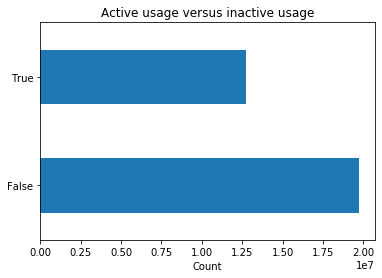

In [23]:
apps.is_active.value_counts().plot(kind='barh')
plt.title('Active usage versus inactive usage')
plt.xlabel('Count')

### Phone Brand

I am still working on getting the phone brand viz aspect 

In [0]:
phone["Brands"] = pd.get_dummies(phone.device_model)

ValueError: ignored

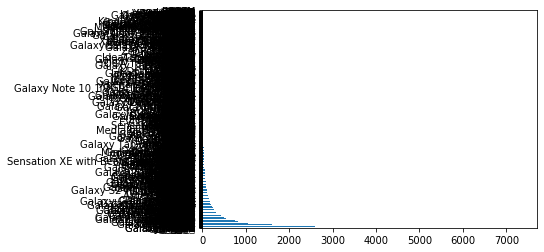

In [0]:

#phone_brand	device_model

phone.device_model.value_counts().plot(kind='barh')